In [1]:
import sys
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
img_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = MNIST(root='data',download=True,train=True,transform=img_transform)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = MNIST(root='data',download=True,train=False,transform=img_transform)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=c,kernel_size=4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(in_channels=c,out_channels=c*2,kernel_size=4,stride=2,padding=1)
        self.fc_mu = nn.Linear(in_features=c*2*7*7,out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7,out_features=latent_dims)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0),-1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu,x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims,out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2,out_channels=c,kernel_size=4,stride=2,padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c,out_channels=1,kernel_size=4,stride=2,padding=1)
    def forward(self,x):
        x = self.fc(x)
        x = x.view(x.size(0),capacity*2,7,7)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self,x):
        latent_mu,latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu,latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon,latent_mu,latent_logvar
    def latent_sample(self,mu,logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
def vae_loss(recon_x,x,mu,logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),reduction='sum')
    kldivergence = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return recon_loss+variational_beta*kldivergence

In [5]:
vae = VariationalAutoencoder()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(num_params)

308357


In [6]:
optimizer = torch.optim.Adam(params=vae.parameters(),lr=learning_rate,weight_decay=1e-5)
vae.train()
train_loss_avg = []
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for image_batch,_ in train_dataloader:
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        loss = vae_loss(image_batch_recon,image_batch,latent_mu,latent_logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1]/=num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1,num_epochs,train_loss_avg[-1]))

Epoch [1 / 100] average reconstruction error: 24116.853237
Epoch [2 / 100] average reconstruction error: 21392.784103
Epoch [3 / 100] average reconstruction error: 20699.712449
Epoch [4 / 100] average reconstruction error: 20328.179996
Epoch [5 / 100] average reconstruction error: 20122.657553
Epoch [6 / 100] average reconstruction error: 19990.700645
Epoch [7 / 100] average reconstruction error: 19885.627020
Epoch [8 / 100] average reconstruction error: 19813.570317
Epoch [9 / 100] average reconstruction error: 19751.457439
Epoch [10 / 100] average reconstruction error: 19680.818647
Epoch [11 / 100] average reconstruction error: 19635.231968
Epoch [12 / 100] average reconstruction error: 19582.959126
Epoch [13 / 100] average reconstruction error: 19538.102756
Epoch [14 / 100] average reconstruction error: 19504.652993
Epoch [15 / 100] average reconstruction error: 19458.173033
Epoch [16 / 100] average reconstruction error: 19430.875727
Epoch [17 / 100] average reconstruction error: 19

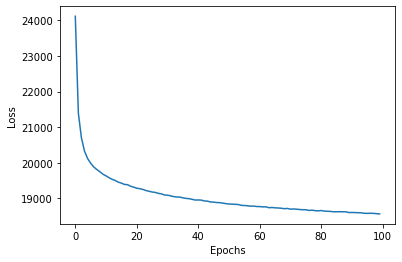

In [7]:
import matplotlib.pyplot as plt
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [8]:
vae.eval()
test_loss_avg, num_batches = 0,0
for image_batch, _ in test_dataloader:
    with torch.no_grad():
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        loss = vae_loss(image_batch_recon,image_batch,latent_mu,latent_logvar)
        test_loss_avg += loss.item()
        num_batches += 1
test_loss_avg /= num_batches
print(test_loss_avg)

19217.435855913765


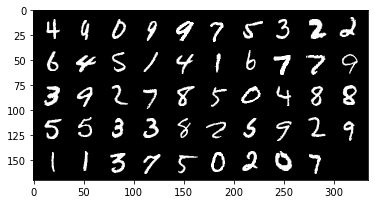

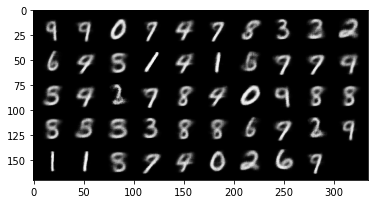

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils
vae.eval()
def to_img(x):
    x = x.clamp(0,1)
    return x
def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
def visualise_output(images,model):
    with torch.no_grad():
        images = images.to(device)
        images,_,_=model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50],10,5).numpy()
        plt.imshow(np.transpose(np_imagegrid,(1,2,0)))
        plt.show()
images,labels = iter(test_dataloader).next()
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()
visualise_output(images,vae)

In [11]:
digits = [[] for _ in range(10)]
print(digits)

[[], [], [], [], [], [], [], [], [], []]


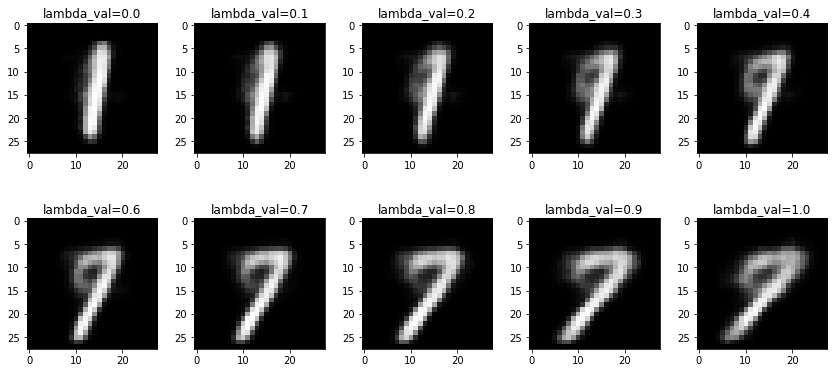

In [16]:
vae.eval()
def interpolation(lambda1,model,img1,img2):
    with torch.no_grad():
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        inter_latent = lambda1*latent_1 + (1-lambda1)*latent_2
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

digits = [[] for _ in range(10)]
for img_batch,label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;
lambda_range = np.linspace(0,1,10)
fig,axs = plt.subplots(2,5,figsize=(15,6))
fig.subplots_adjust(hspace=.5,wspace=.001)
axs = axs.ravel()
for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l),vae,digits[7][0],digits[1][0])
    inter_image = to_img(inter_image)
    image = inter_image.numpy()
    axs[ind].imshow(image[0,0,:,:],cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

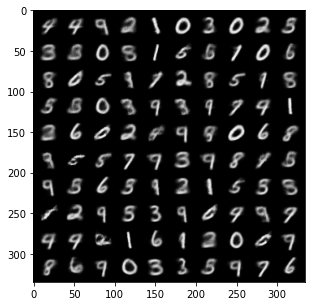

In [17]:
vae.eval()
with torch.no_grad():
    latent = torch.randn(128,latent_dims,device=device)
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()
    fig,ax = plt.subplots(figsize=(5,5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()